In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path =  '/content/drive/MyDrive/MAANG_Stocks'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [ ]:
companies = ['Microsoft', 'Amazon', 'Apple', 'Netflix', 'Google']
data_path = '/content/drive/MyDrive/MAANG_Stocks/'

dfs = {}

for company in companies:
    df = pd.read_csv(f'{data_path}{company}.csv')
    df['Company'] = company
    dfs[company] = df

# Combine all into one DataFrame
full_df = pd.concat(dfs.values(), ignore_index=True)
full_df.head()


,Open,High,Low,Close,Adj Close,Volume,Date,Company
0,58.68750,59.3125,56.00000,58.28125,36.361576,53228400,2000-01-03,Microsoft
1,56.78125,58.5625,56.12500,56.31250,35.133263,54119000,2000-01-04,Microsoft
2,55.56250,58.1875,54.68750,56.90625,35.503712,64059600,2000-01-05,Microsoft
3,56.09375,56.9375,54.18750,55.00000,34.314400,54976600,2000-01-06,Microsoft
4,54.31250,56.1250,53.65625,55.71875,34.762833,62013600,2000-01-07,Microsoft


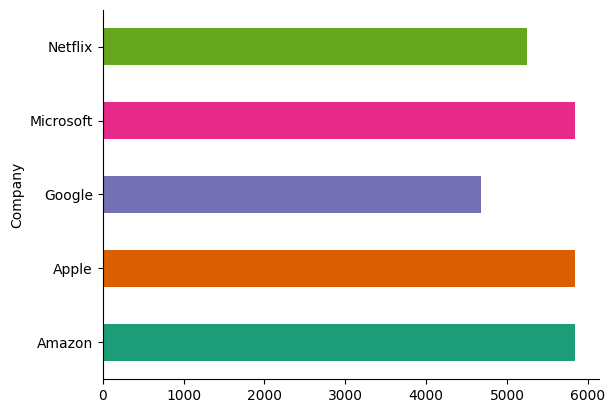

In [ ]:
# @title Company

from matplotlib import pyplot as plt
import seaborn as sns
full_df.groupby('Company').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Check missing values
print(full_df.isnull().sum())

# Drop rows with missing values or fill them
full_df.dropna(inplace=True)


Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Date         0
Company      0
dtype: int64


In [ ]:
full_df['Date'] = pd.to_datetime(full_df['Date'])
full_df.sort_values(['Company', 'Date'], inplace=True)


In [ ]:
# Save cleaned dataset
cleaned_path = '/content/drive/MyDrive/MAANG_Stocks/cleaned_maang.csv'
full_df.to_csv(cleaned_path, index=False)


In [ ]:
# Basic statistics
summary = full_df.groupby('Company')[['Open', 'High', 'Low', 'Close', 'Volume']].describe()
summary


Open                                                           \
            count        mean         std        min        25%        50%   
Company                                                                      
Amazon     5839.0   34.865886   49.577395   0.295500   2.209188   9.449500   
Apple      5839.0   30.964461   44.291183   0.231964   1.931965  13.321429   
Google     4677.0   38.255309   35.540477   2.470490  12.657307  25.577278   
Microsoft  5839.0   70.465994   76.981188  15.200000  26.969375  31.781250   
Netflix    5241.0  122.076674  168.295608   0.377857   4.038571  30.442858   

                                     High              ...       Close  \
                  75%         max   count        mean  ...         75%   
Company                                                ...               
Amazon      47.835499  187.199997  5839.0   35.280858  ...   47.833000   
Apple       36.438751  182.630005  5839.0   31.318350  ...   36.577499   
Google      54.528500  151.863495  4677.0   38.656113  ...   54.546501   
Microsoft   69.119999  344.619995  5839.0   71.213594  ...   69.305000   
Netflix    191.610001  692.349976  5241.0  123.994434  ...  190.850006   

                       Volume                                          \
                  max   count          mean           std         min   
Company                                                                 
Amazon     186.570496  5839.0  1.239786e+08  9.910548e+07  17626000.0   
Apple      182.009995  5839.0  4.112873e+08  3.867277e+08  35195900.0   
Google     150.709000  4677.0  1.226090e+08  1.529406e+08    158434.0   
Microsoft  343.109985  5839.0  5.206855e+07  3.085185e+07   7425600.0   
Netflix    691.690002  5241.0  1.628071e+07  1.895990e+07    285600.0   

                                                                
                   25%          50%          75%           max  
Company                                                         
Amazon      67982000.0  101548000.0  147970000.0  2.086584e+09  
Apple      138435600.0  294224000.0  547639400.0  7.421641e+09  
Google      29684000.0   66986143.0  152794573.0  1.650833e+09  
Microsoft   29623450.0   47000800.0   65728700.0  5.910522e+08  
Netflix      6179100.0   10423700.0   19395600.0  3.234140e+08  

[5 rows x 40 columns]

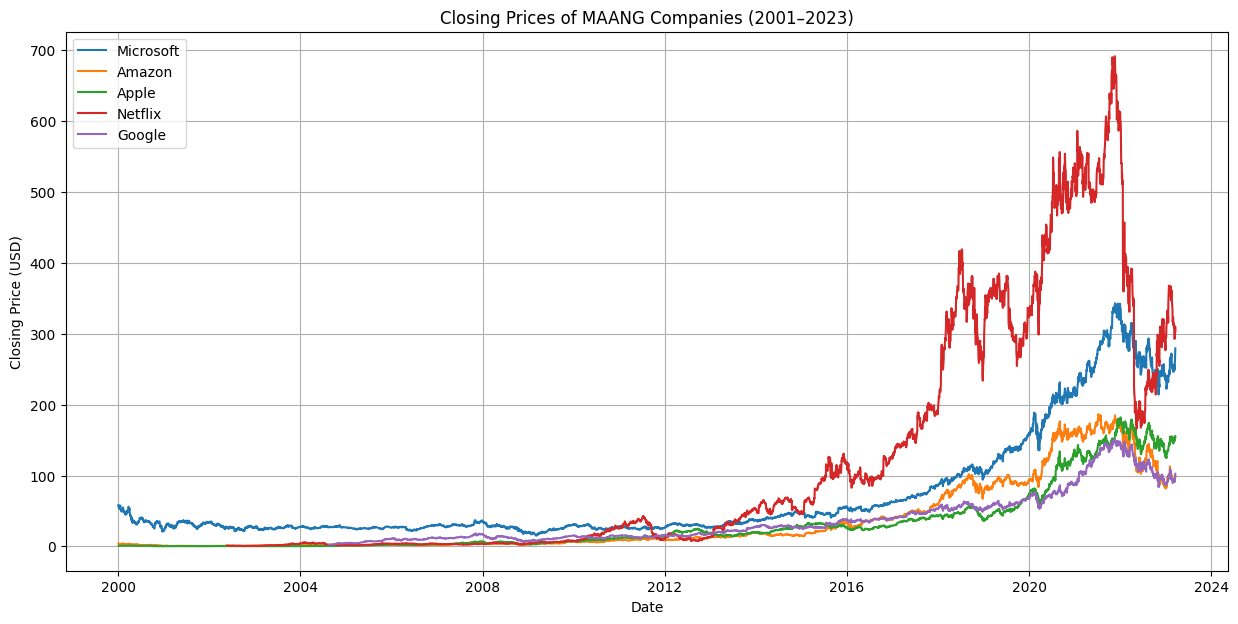

In [ ]:
plt.figure(figsize=(15, 7))
for company in companies:
    df = full_df[full_df['Company'] == company]
    plt.plot(df['Date'], df['Close'], label=company)

plt.title('Closing Prices of MAANG Companies (2001–2023)')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


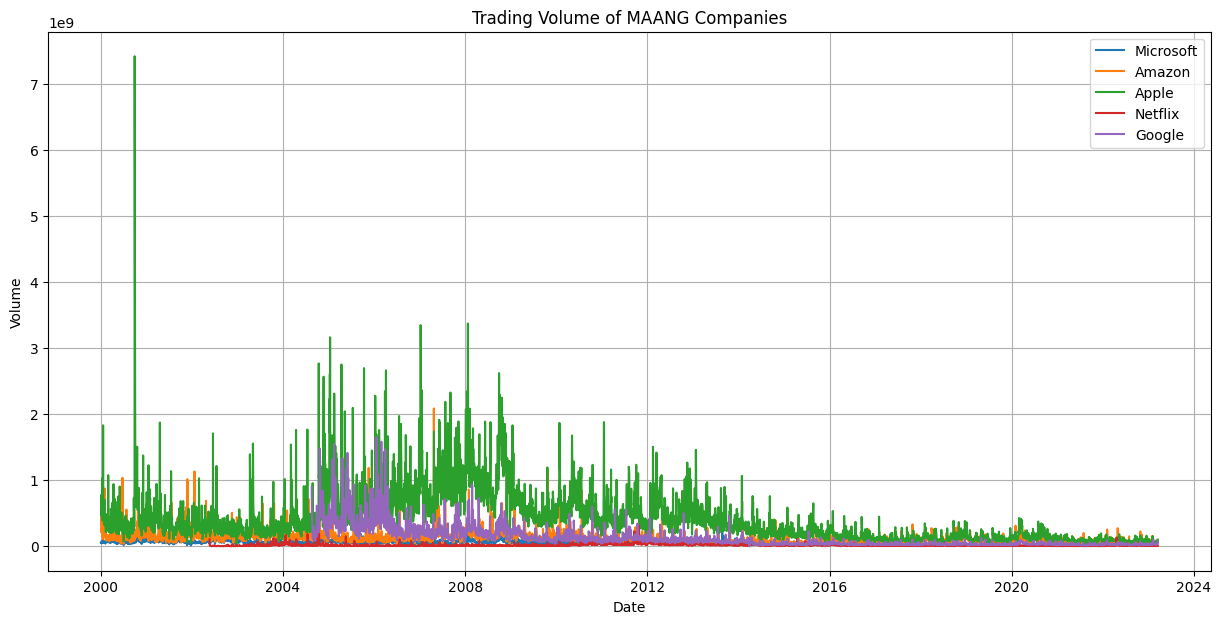

In [ ]:
plt.figure(figsize=(15, 7))
for company in companies:
    df = full_df[full_df['Company'] == company]
    plt.plot(df['Date'], df['Volume'], label=company)

plt.title('Trading Volume of MAANG Companies')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()


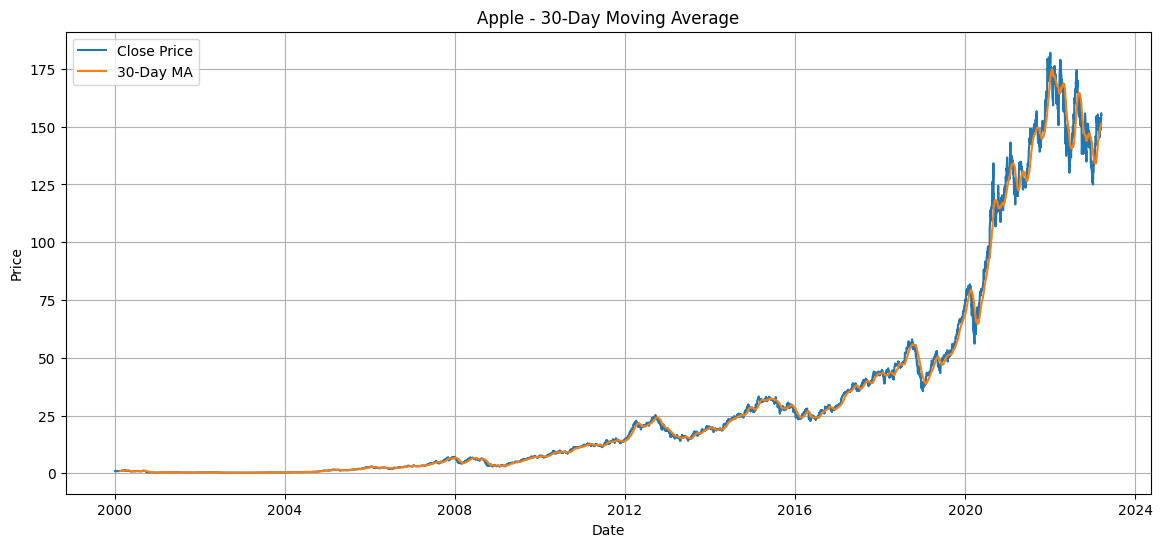

In [ ]:
# Example: 30-day moving average for Apple
apple_df = full_df[full_df['Company'] == 'Apple'].copy()
apple_df['MA30'] = apple_df['Close'].rolling(window=30).mean()

plt.figure(figsize=(14, 6))
plt.plot(apple_df['Date'], apple_df['Close'], label='Close Price')
plt.plot(apple_df['Date'], apple_df['MA30'], label='30-Day MA')
plt.title('Apple - 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


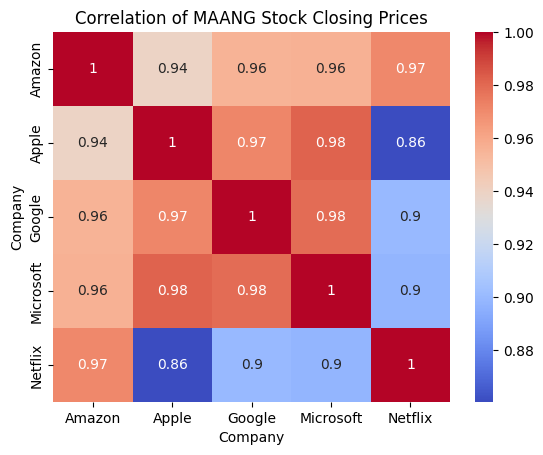

In [ ]:
# Pivot to get date vs companies Close prices
pivot_df = full_df.pivot(index='Date', columns='Company', values='Close')
corr_matrix = pivot_df.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation of MAANG Stock Closing Prices")
plt.show()


  # ARIMA Forecast for MAANG Dataset

 Forecasting for: Amazon


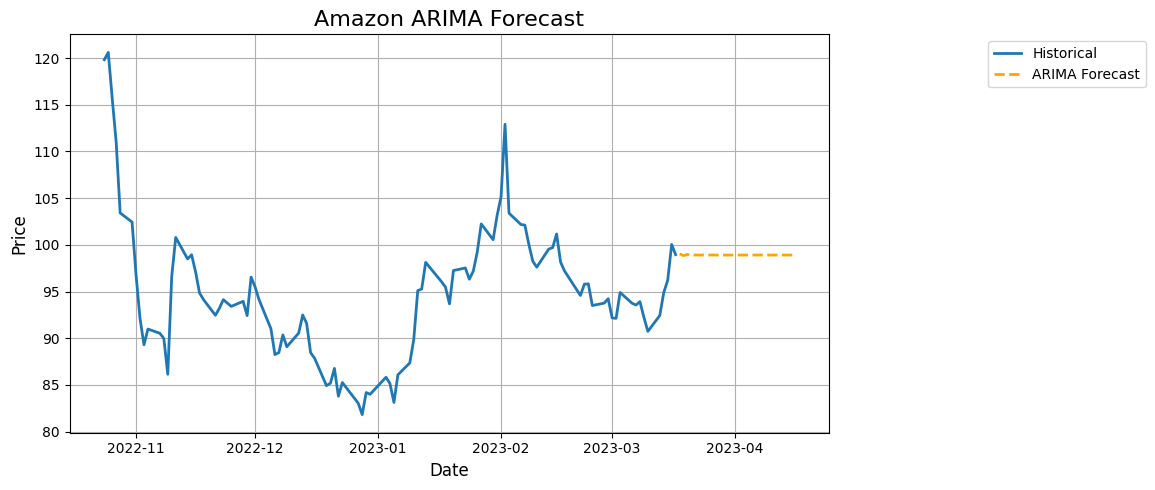

 Forecasting for: Apple


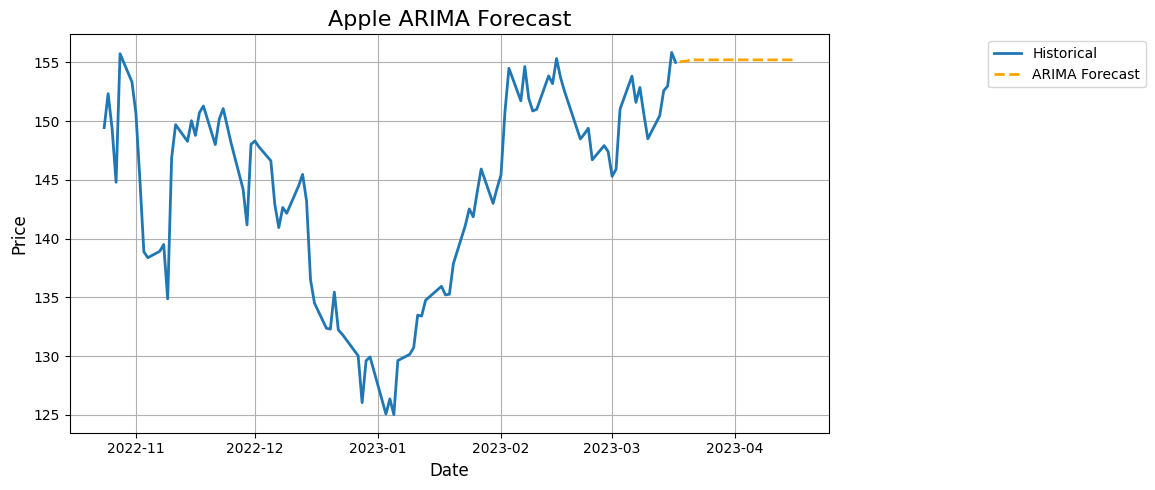

 Forecasting for: Google


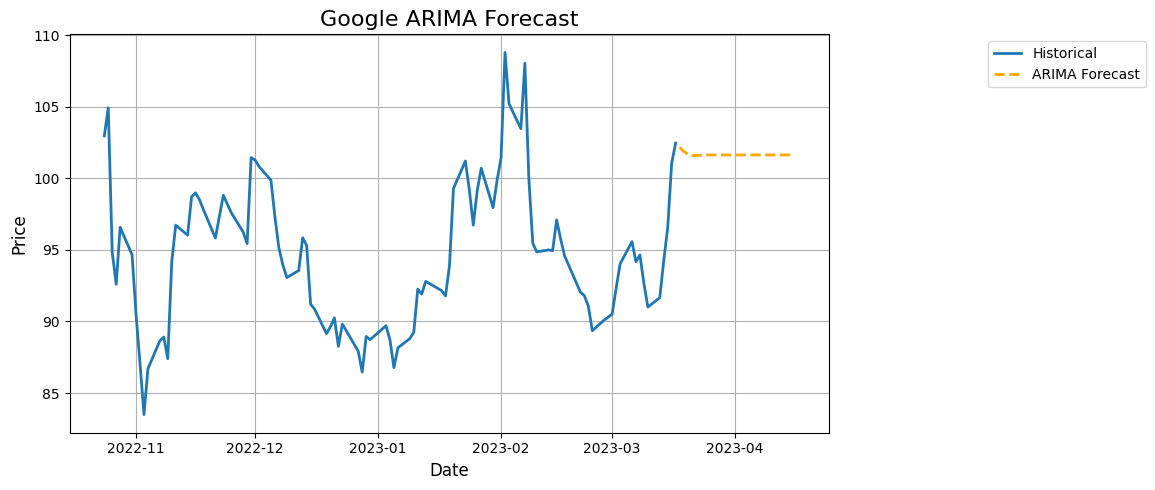

 Forecasting for: Microsoft


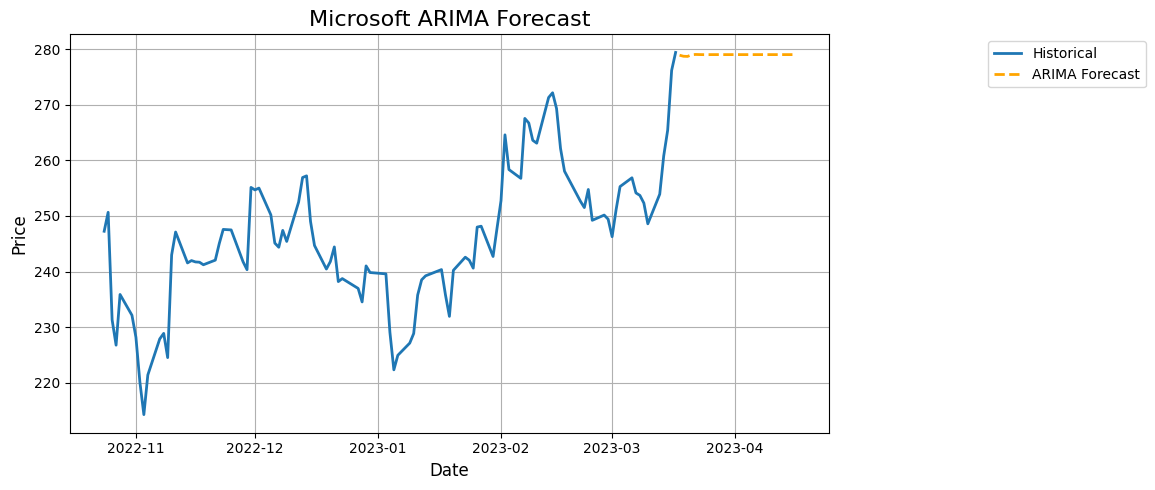

 Forecasting for: Netflix


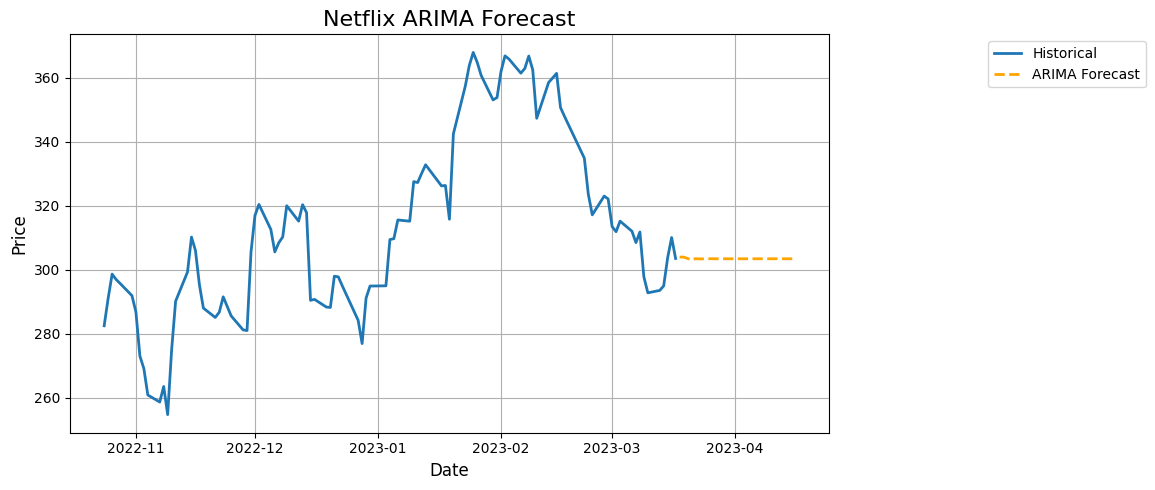

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import os
import warnings
warnings.filterwarnings("ignore")

# Setting up output directory on Google Drive
output_dir = "/content/drive/MyDrive/MAANG_Stocks/ARIMA_Forecasts"
os.makedirs(output_dir, exist_ok=True)

# Getting unique company names
companies = full_df['Company'].unique()

# Forecasting horizon
n_steps = 30

for company in companies:
    print(f" Forecasting for: {company}")

    try:
        # Filter and prepare data
        company_df = full_df[full_df['Company'] == company].copy()
        company_df['Date'] = pd.to_datetime(company_df['Date'])
        company_df.sort_values('Date', inplace=True)
        company_df.set_index('Date', inplace=True)
        data = company_df[['Close']]

        # Fit ARIMA model
        model = ARIMA(data['Close'], order=(5, 1, 0))
        result = model.fit()

        # Forecast
        forecast = result.forecast(steps=n_steps)

        # Create future dates
        last_date = data.index[-1]
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_steps)
        forecast_df = pd.DataFrame({'Date': future_dates, 'ARIMA_Predicted_Close': forecast})
        forecast_df.set_index('Date', inplace=True)

        # Plot
        plt.figure(figsize=(12, 5))
        plt.plot(data['Close'].iloc[-100:], label='Historical', linewidth=2)
        plt.plot(forecast_df, label='ARIMA Forecast', linestyle='--', linewidth=2, color='orange')
        plt.title(f"{company} ARIMA Forecast", fontsize=16)
        plt.xlabel("Date", fontsize=12)
        plt.ylabel("Price", fontsize=12)
        plt.legend(loc='upper left', bbox_to_anchor=(1.2, 1), fontsize=10)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error forecasting for {company}: {e}")

# SARIMAX Forecast for MAANG Dataset

 Forecasting SARIMA for: Amazon


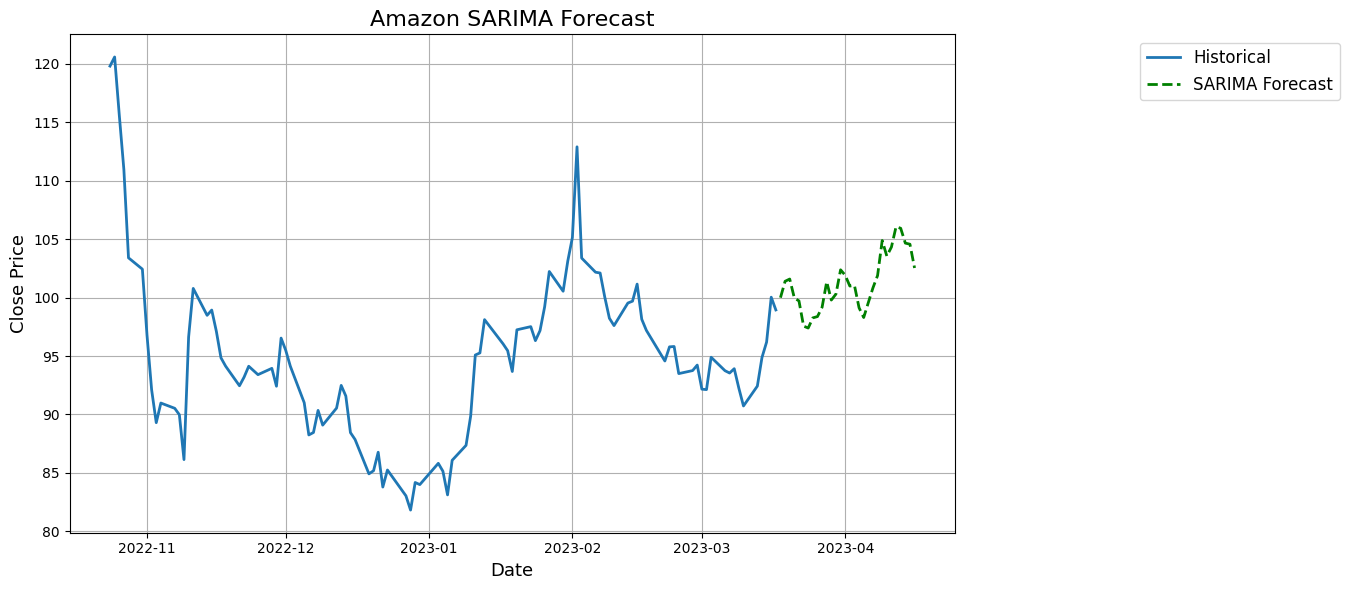

 Forecasting SARIMA for: Apple


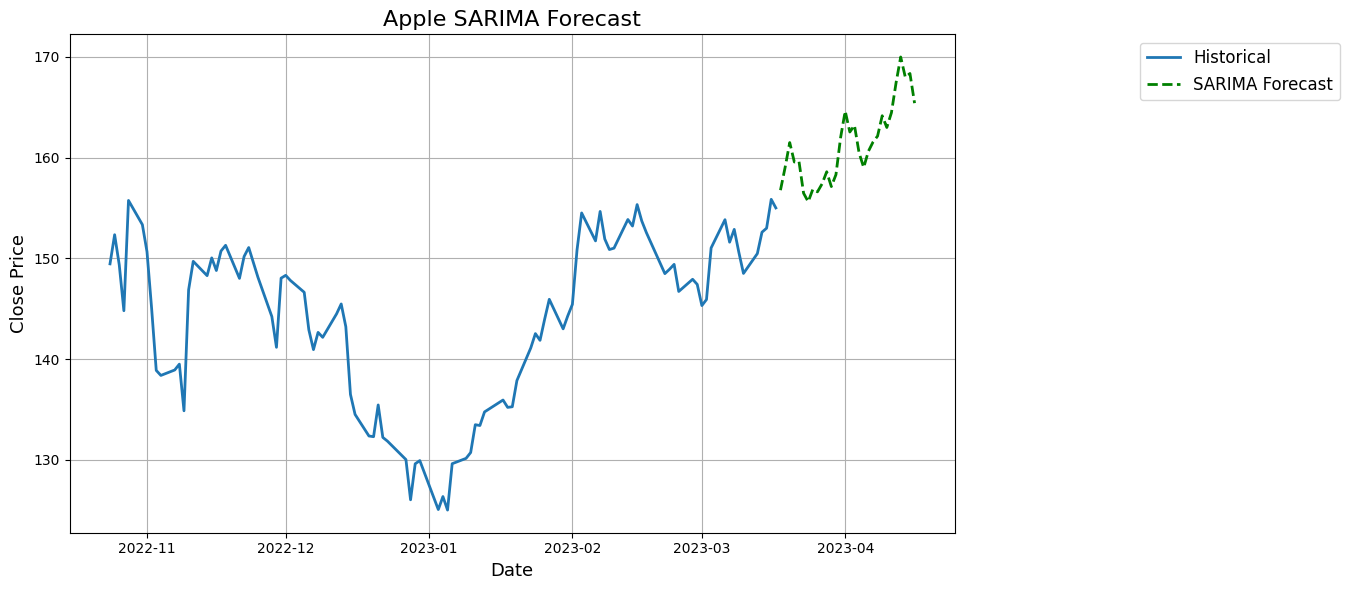

 Forecasting SARIMA for: Google


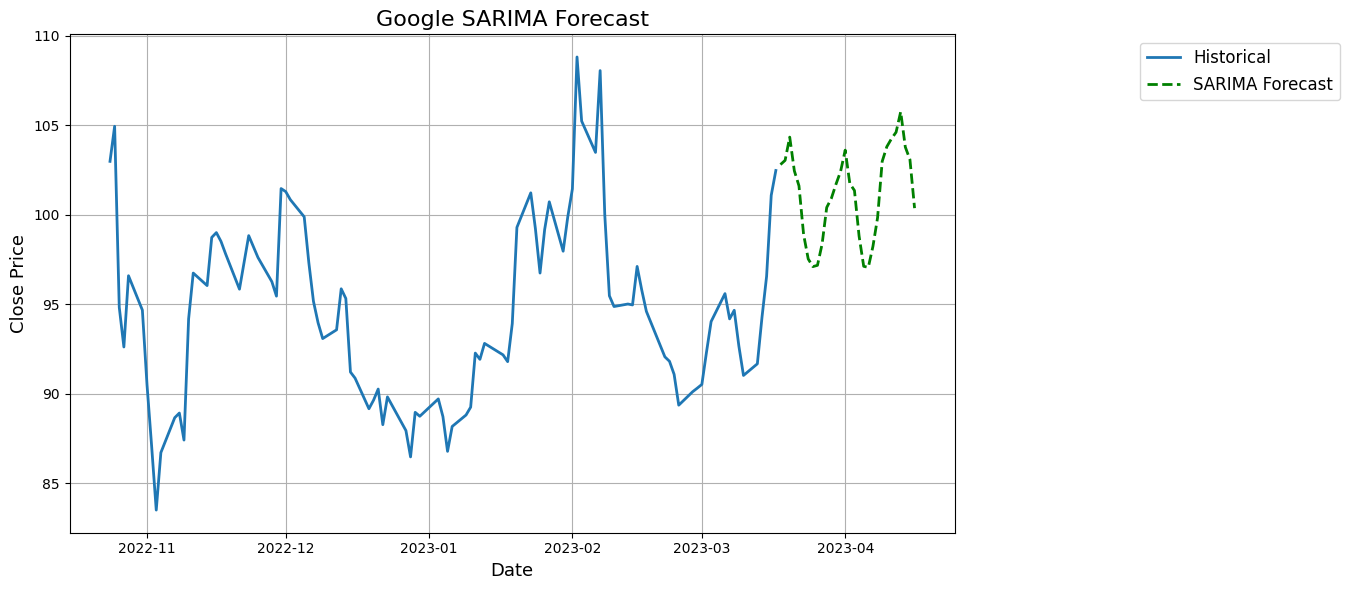

 Forecasting SARIMA for: Microsoft


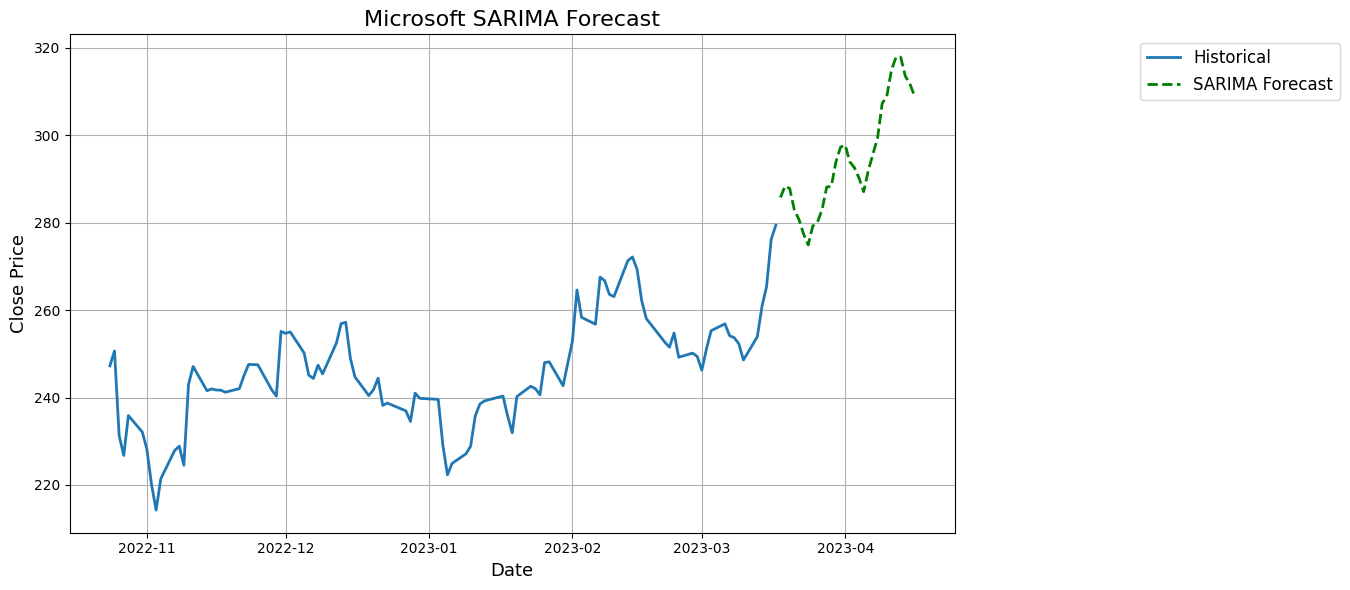

 Forecasting SARIMA for: Netflix


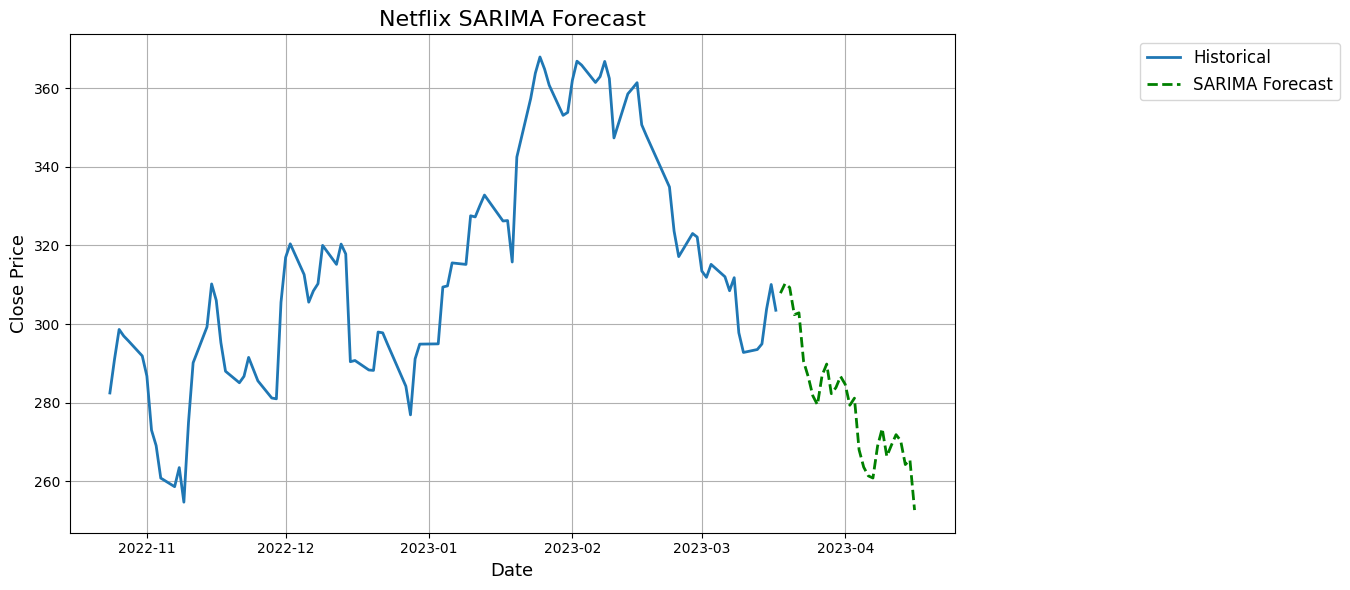

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import os
import warnings
warnings.filterwarnings("ignore")

# output folder
output_dir = "/content/drive/MyDrive/MAANG_Stocks/SARIMA_Forecasts"
os.makedirs(output_dir, exist_ok=True)

companies = full_df['Company'].unique()
n_steps = 30  # Forecast steps

# Loop through each company
for company in companies:
    print(f" Forecasting SARIMA for: {company}")

    try:
        # Filter and prepare data
        company_df = full_df[full_df['Company'] == company].copy()
        company_df['Date'] = pd.to_datetime(company_df['Date'])
        company_df.sort_values('Date', inplace=True)
        company_df.set_index('Date', inplace=True)
        data = company_df[['Close']]

        # Fit SARIMA model: (p,d,q)x(P,D,Q,s)
        # Using default disp=False to prevent verbose output
        model = SARIMAX(data['Close'],
                        order=(1, 1, 1),
                        seasonal_order=(1, 1, 0, 12))
        result = model.fit(disp=False)

        # Forecast
        forecast = result.forecast(steps=n_steps)

        # Generate future dates
        last_date = data.index[-1]
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_steps)

        forecast_df = pd.DataFrame({'Date': future_dates, 'SARIMA_Predicted_Close': forecast})
        forecast_df.set_index('Date', inplace=True)

        # Plot
        plt.figure(figsize=(14, 6))
        plt.plot(data['Close'].iloc[-100:], label='Historical', linewidth=2)
        plt.plot(forecast_df['SARIMA_Predicted_Close'], label='SARIMA Forecast', linestyle='--', color='green', linewidth=2)
        plt.title(f"{company} SARIMA Forecast", fontsize=16)
        plt.xlabel("Date", fontsize=13)
        plt.ylabel("Close Price", fontsize=13)
        plt.legend(loc='upper left', bbox_to_anchor=(1.2, 1), fontsize=12)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error forecasting for {company}: {e}")

# Prophet Forecast for MAANG Dataset

Forecasting Prophet for: Amazon


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeowug27s/to8t7yux.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeowug27s/806odtc2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65686', 'data', 'file=/tmp/tmpeowug27s/to8t7yux.json', 'init=/tmp/tmpeowug27s/806odtc2.json', 'output', 'file=/tmp/tmpeowug27s/prophet_modele5y2ctl0/prophet_model-20250621115604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:56:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:56:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


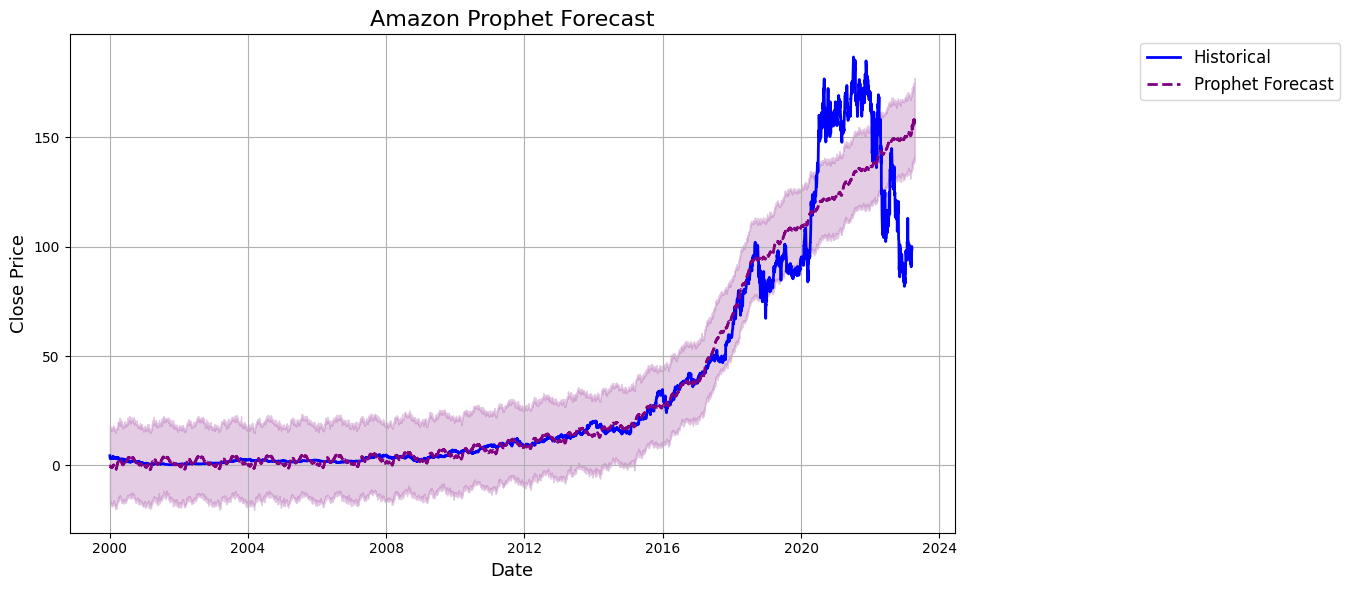

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeowug27s/_7gtnk4k.json


Forecasting Prophet for: Apple


DEBUG:cmdstanpy:input tempfile: /tmp/tmpeowug27s/cdxbejtk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5498', 'data', 'file=/tmp/tmpeowug27s/_7gtnk4k.json', 'init=/tmp/tmpeowug27s/cdxbejtk.json', 'output', 'file=/tmp/tmpeowug27s/prophet_modelxr0_p9ie/prophet_model-20250621115607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:56:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:56:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


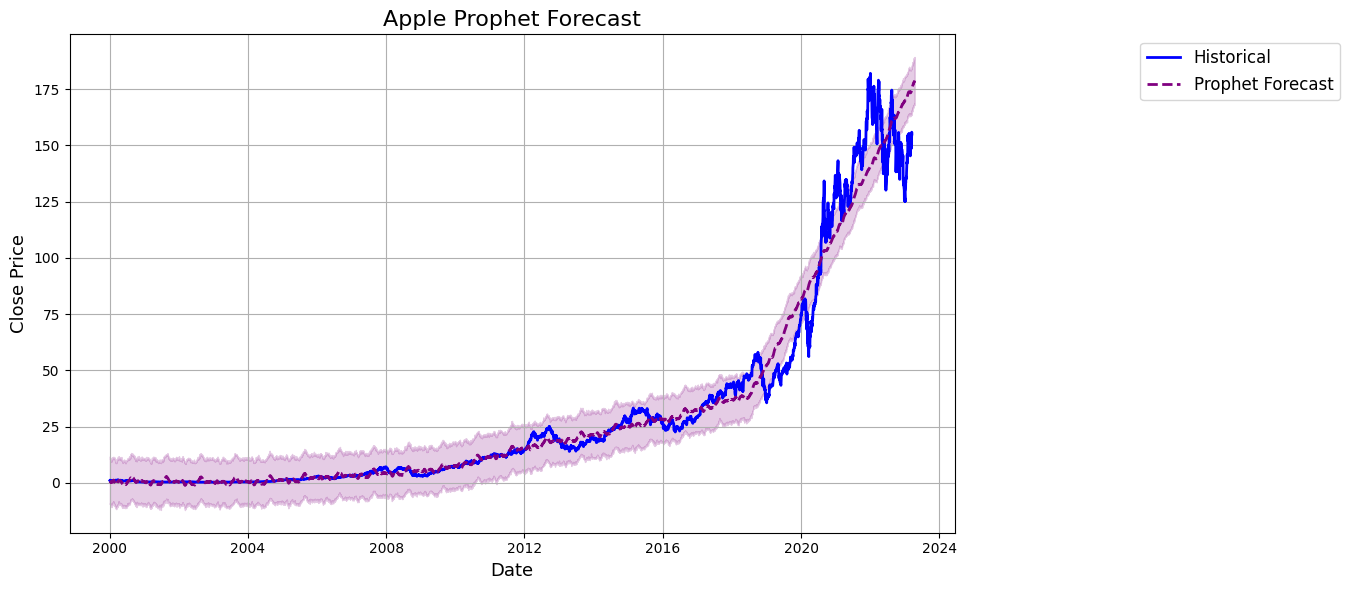

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeowug27s/sa_tjrag.json


Forecasting Prophet for: Google


DEBUG:cmdstanpy:input tempfile: /tmp/tmpeowug27s/eptcuwt1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66172', 'data', 'file=/tmp/tmpeowug27s/sa_tjrag.json', 'init=/tmp/tmpeowug27s/eptcuwt1.json', 'output', 'file=/tmp/tmpeowug27s/prophet_model_ypg0rx0/prophet_model-20250621115611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:56:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:56:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


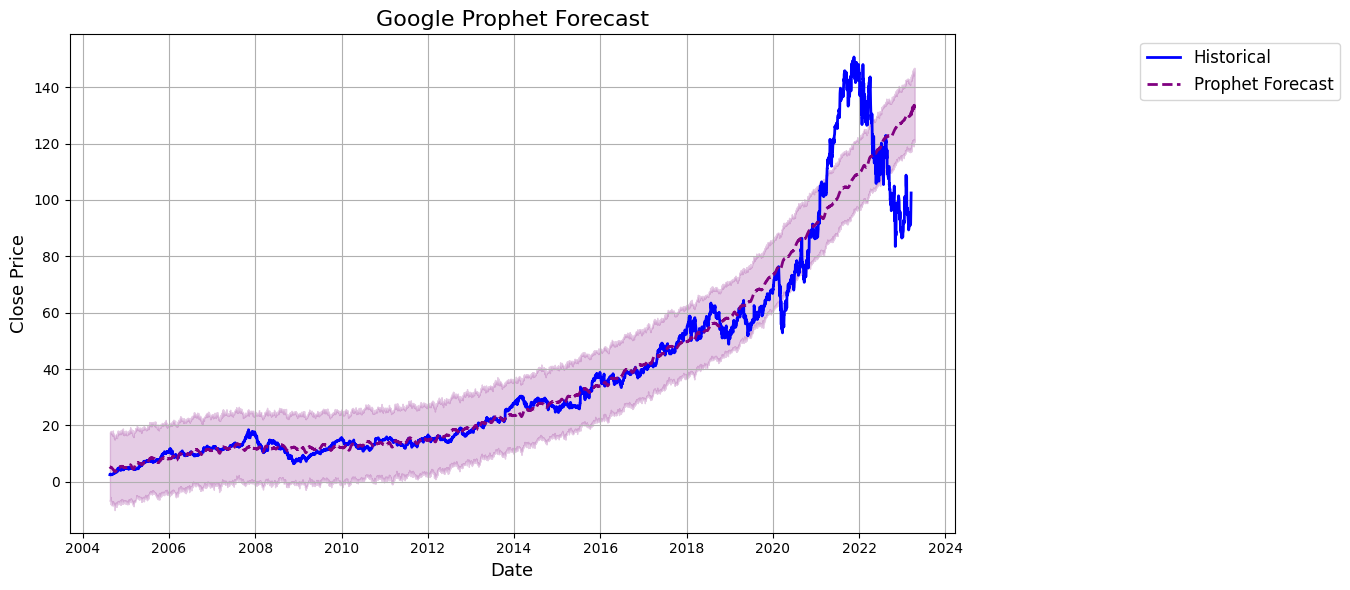

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeowug27s/ft2qizfv.json


Forecasting Prophet for: Microsoft


DEBUG:cmdstanpy:input tempfile: /tmp/tmpeowug27s/0y3ybe0l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99193', 'data', 'file=/tmp/tmpeowug27s/ft2qizfv.json', 'init=/tmp/tmpeowug27s/0y3ybe0l.json', 'output', 'file=/tmp/tmpeowug27s/prophet_modelpx68g5qd/prophet_model-20250621115614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:56:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:56:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


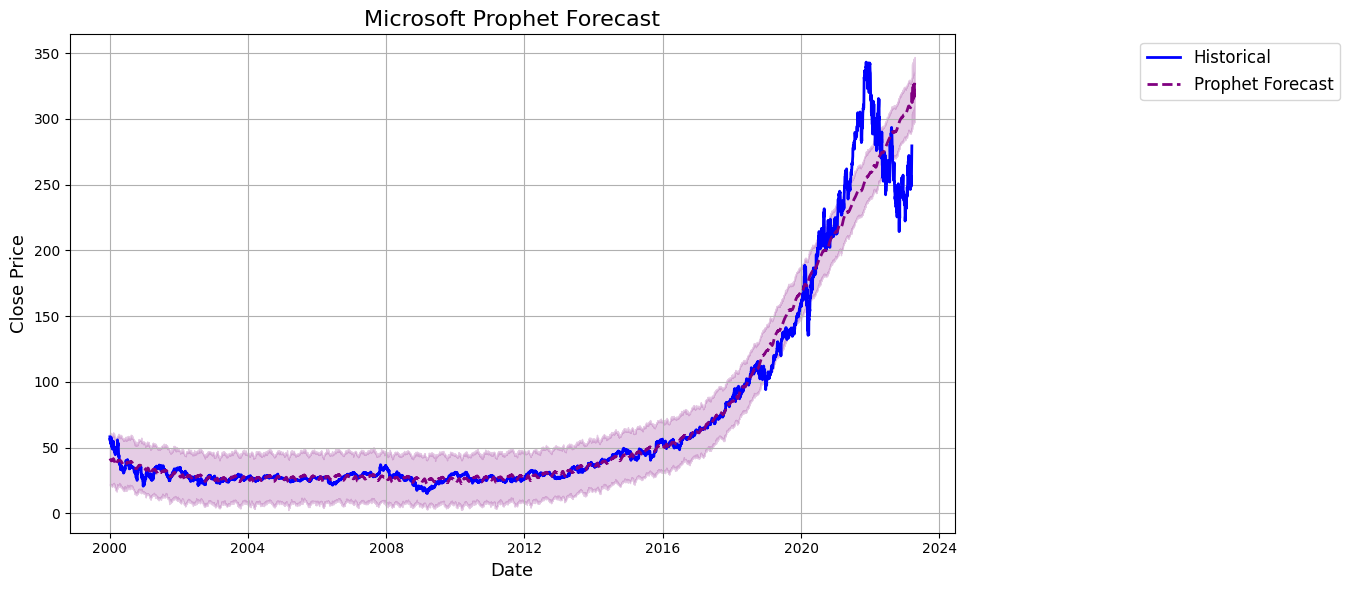

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeowug27s/fndq9x5q.json


Forecasting Prophet for: Netflix


DEBUG:cmdstanpy:input tempfile: /tmp/tmpeowug27s/7nbples2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94016', 'data', 'file=/tmp/tmpeowug27s/fndq9x5q.json', 'init=/tmp/tmpeowug27s/7nbples2.json', 'output', 'file=/tmp/tmpeowug27s/prophet_modeldzxhdf3e/prophet_model-20250621115618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:56:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:56:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


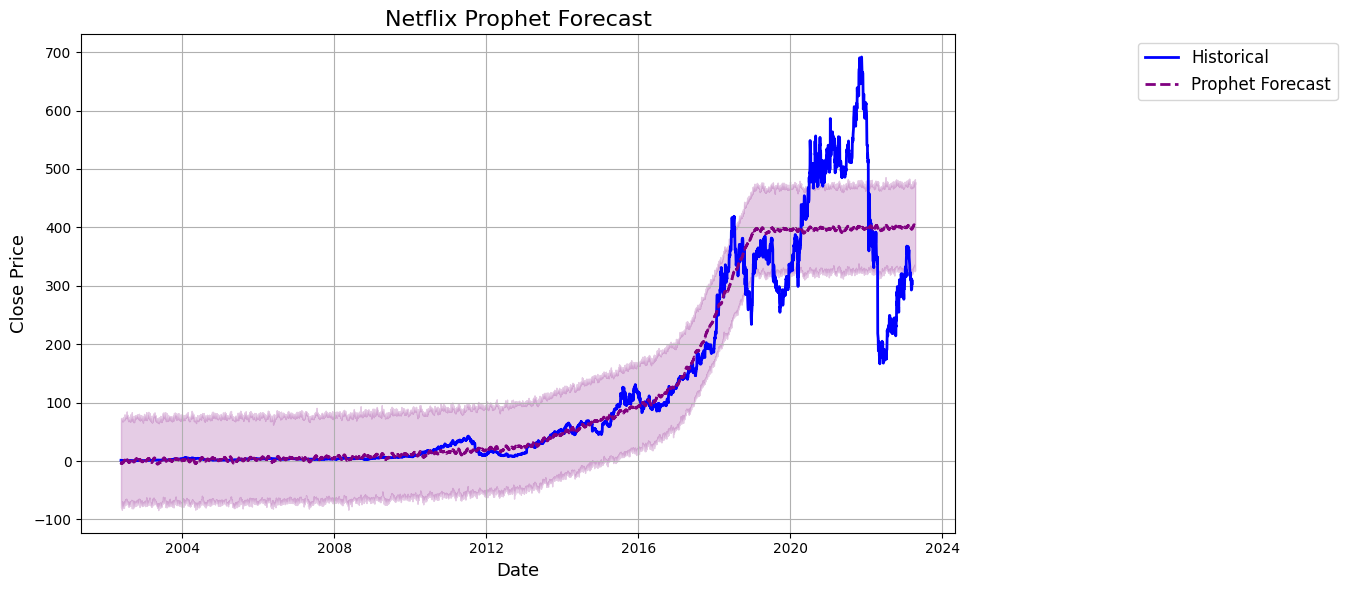

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import os
import warnings
import contextlib

warnings.filterwarnings("ignore")


# Create output folder
forecast_dir = '/content/drive/MyDrive/MAANG_Stocks/Prophet_Forecasts'
os.makedirs(forecast_dir, exist_ok=True)

# Forecast horizon (e.g., 30 days)
n_steps = 30

# Prophet forecast loop
for company in companies:
    print(f"Forecasting Prophet for: {company}")

    try:
        # Filter and clean data
        df = full_df[full_df['Company'] == company].copy()
        df['Date'] = pd.to_datetime(df['Date'])
        df = df[['Date', 'Close']].dropna()
        df = df.sort_values('Date')

        if df.empty:
            print(f" Skipping {company} due to missing data.")
            continue

        # Rename for Prophet format
        prophet_df = df.rename(columns={'Date': 'ds', 'Close': 'y'})

        # Fit Prophet
        with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
            model = Prophet()
            model.fit(prophet_df)

        # Predict future
        future = model.make_future_dataframe(periods=n_steps)
        forecast = model.predict(future)

        # Plot results (aligned correctly)
        plt.figure(figsize=(14, 6))
        plt.plot(prophet_df['ds'], prophet_df['y'], label='Historical', color='blue', linewidth=2)
        plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast', linestyle='--', color='purple', linewidth=2)

        # Optional: Add confidence interval
        plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2, color='purple')

        # Plot settings
        plt.title(f"{company} Prophet Forecast", fontsize=16)
        plt.xlabel("Date", fontsize=13)
        plt.ylabel("Close Price", fontsize=13)
        plt.legend(loc='upper left', bbox_to_anchor=(1.2, 1), fontsize=12)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f" Error for {company}: {e}")


# LSTM Forecast for MAANG Dataset


 LSTM Forecasting for: Amazon


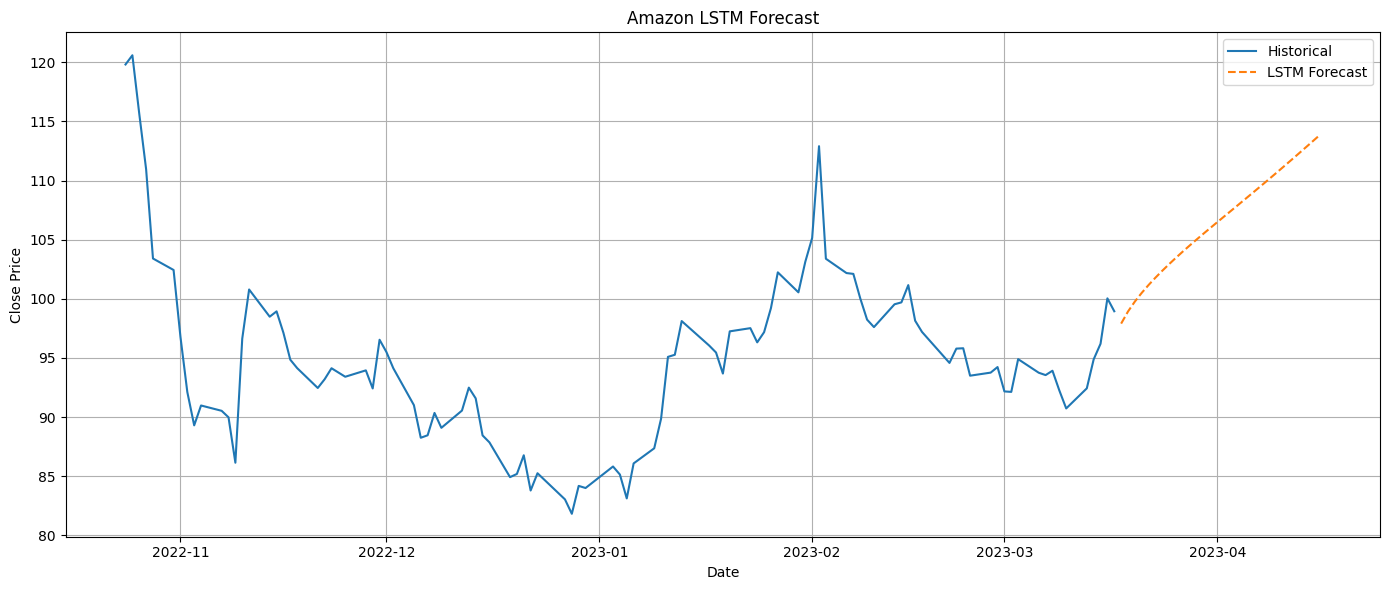


 LSTM Forecasting for: Apple


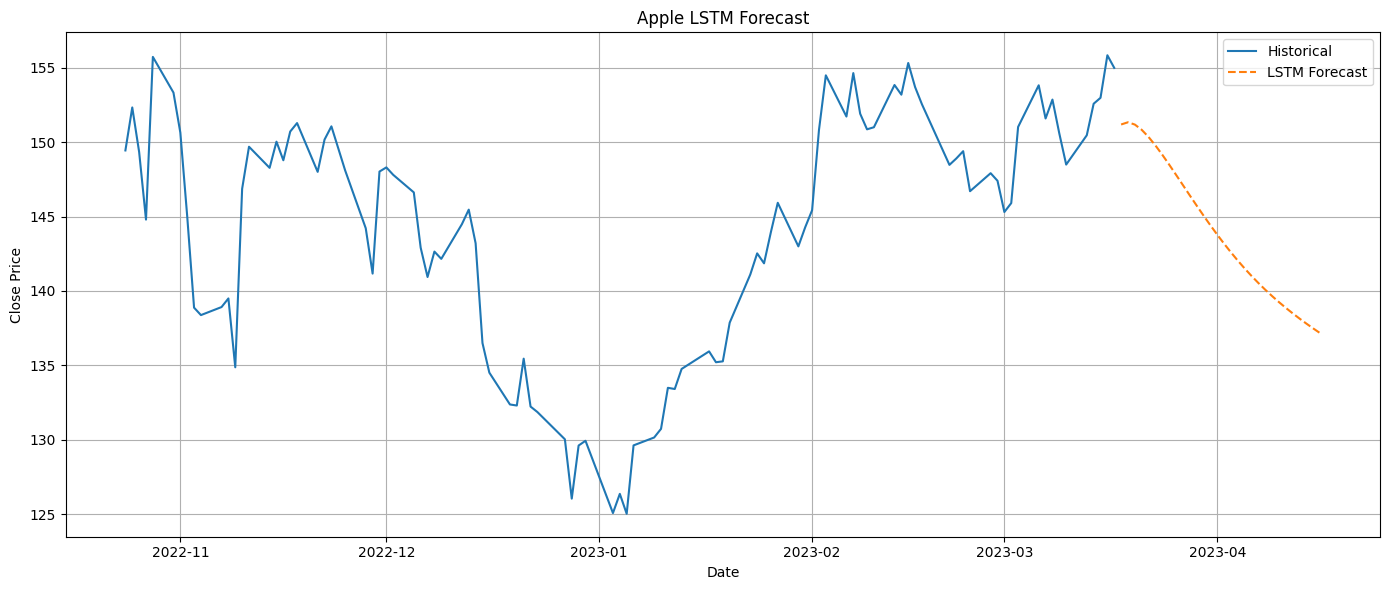


 LSTM Forecasting for: Google


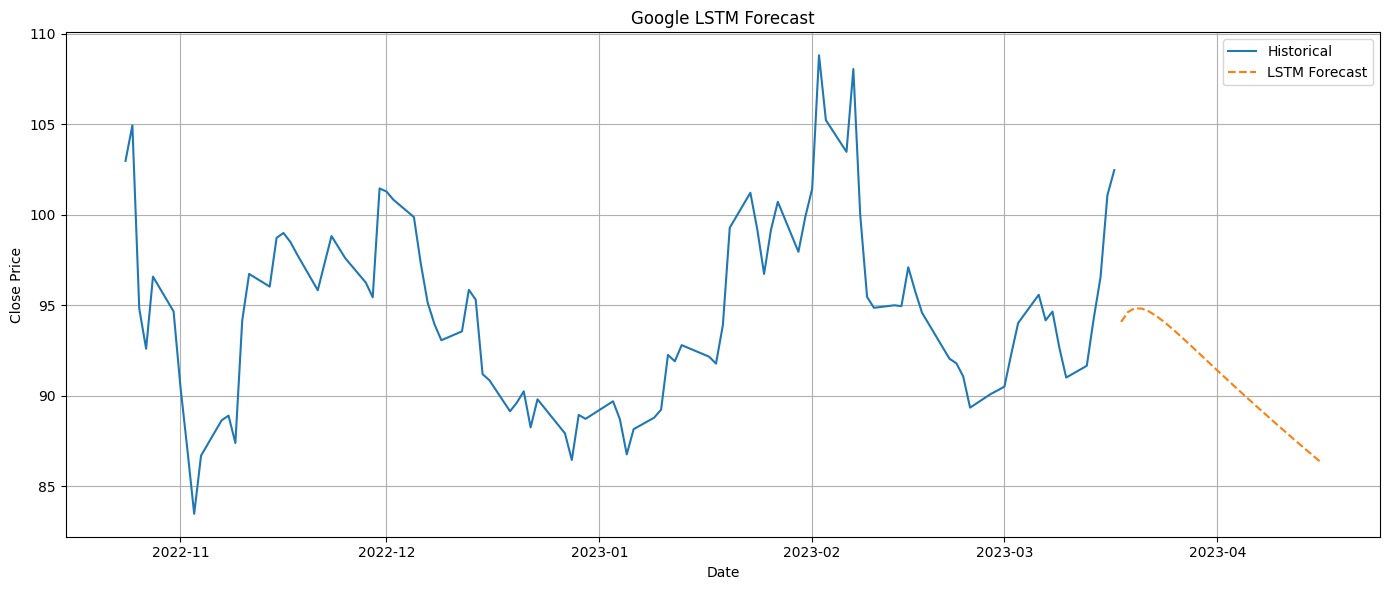


 LSTM Forecasting for: Microsoft


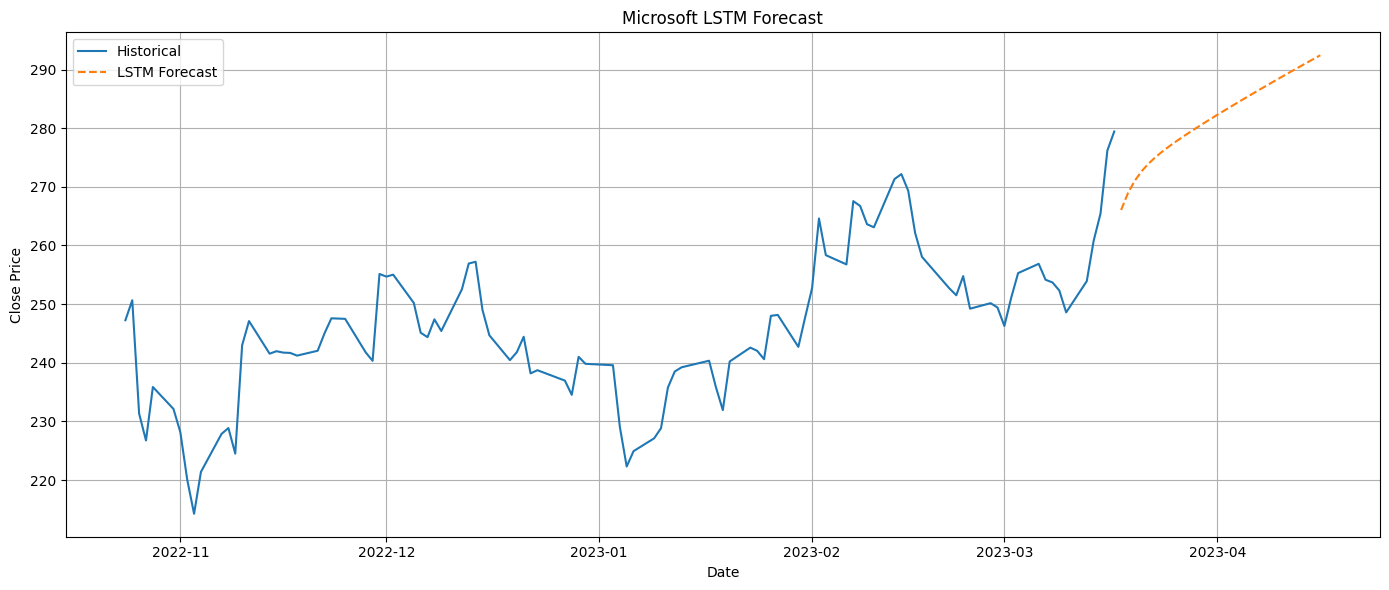


 LSTM Forecasting for: Netflix


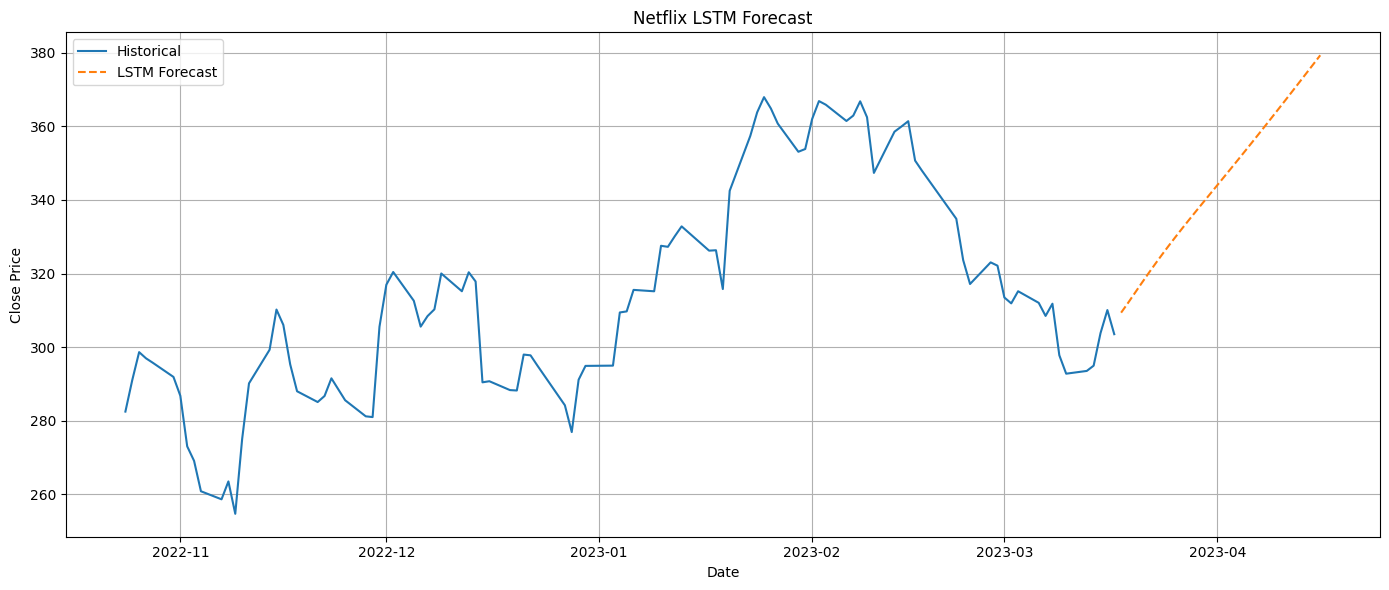

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import os


# Forecast horizon
n_steps = 30

# Loop over all companies
for company in companies:
    print(f"\n LSTM Forecasting for: {company}")

    try:
        df = full_df[full_df['Company'] == company].copy()
        df['Date'] = pd.to_datetime(df['Date'])
        df.sort_values('Date', inplace=True)
        df.set_index('Date', inplace=True)

        if df.empty or 'Close' not in df.columns:
            print(f" Skipping {company}: No data.")
            continue

        close_data = df[['Close']].values

        # Normalize
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(close_data)

        # Create sequences
        X, y = [], []
        for i in range(60, len(scaled_data)):
            X.append(scaled_data[i-60:i, 0])
            y.append(scaled_data[i, 0])

        X, y = np.array(X), np.array(y)
        X = X.reshape((X.shape[0], X.shape[1], 1))

        # Build LSTM
        model = Sequential()
        model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
        model.add(LSTM(50))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(X, y, epochs=10, batch_size=32, verbose=0)

        # Forecast next 30 days
        input_seq = scaled_data[-60:]
        input_seq = input_seq.reshape(1, 60, 1)
        lstm_preds = []

        for _ in range(n_steps):
            pred = model.predict(input_seq, verbose=0)[0][0]
            lstm_preds.append(pred)
            input_seq = np.append(input_seq[:, 1:, :], [[[pred]]], axis=1)

        preds_actual = scaler.inverse_transform(np.array(lstm_preds).reshape(-1, 1))

        future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=n_steps)
        forecast_df = pd.DataFrame({'Date': future_dates, 'LSTM_Predicted_Close': preds_actual.flatten()})
        forecast_df.set_index('Date', inplace=True)

        # Plot
        plt.figure(figsize=(14, 6))
        plt.plot(df.index[-100:], df['Close'][-100:], label='Historical')
        plt.plot(forecast_df.index, forecast_df['LSTM_Predicted_Close'], label='LSTM Forecast', linestyle='--')
        plt.title(f"{company} LSTM Forecast")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f" Error for {company}: {e}")
